In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sgd import *
from collections import Counter
import random
from probability import *
from stats import *
sns.set_context('poster')

In [2]:
def bucketize(point, bucket_size):
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    return Counter(bucketize(point, bucket_size)
                   for point in points)

def plot_histogram(points, bucket_size, title = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width = bucket_size)
    plt.title(title)
    plt.show()

In [3]:
random.seed(0)

uniform = [200 * random.random() - 100 for _ in range(10000)]

normal = [57 * inverse_normal_cdf(random.random())
         for _ in range(10000)]

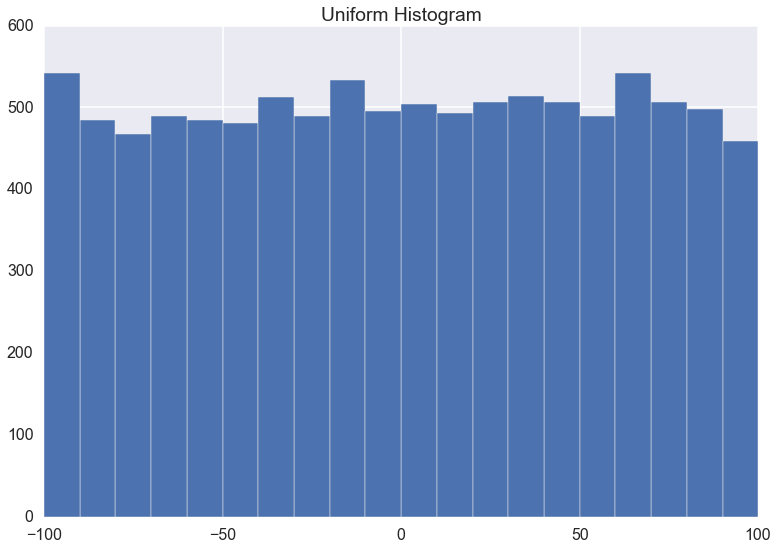

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

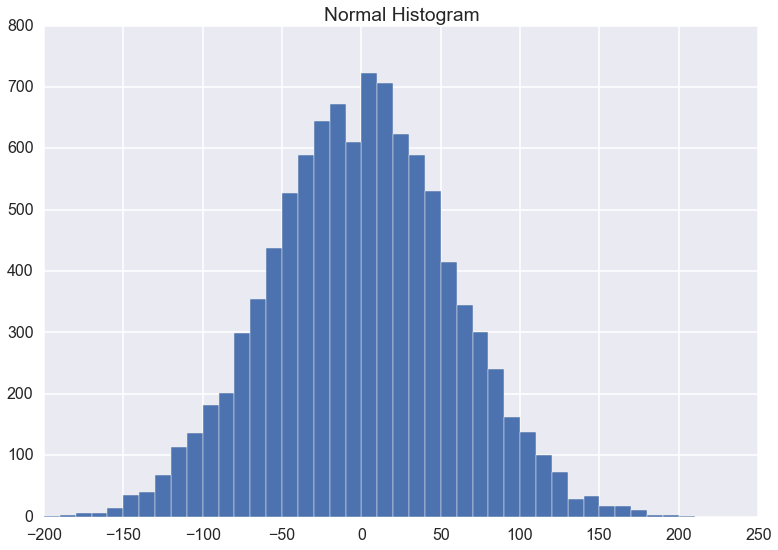

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

In [6]:
def random_normal():
    return inverse_normal_cdf(random.random())

In [7]:
xs = [random_normal() for _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

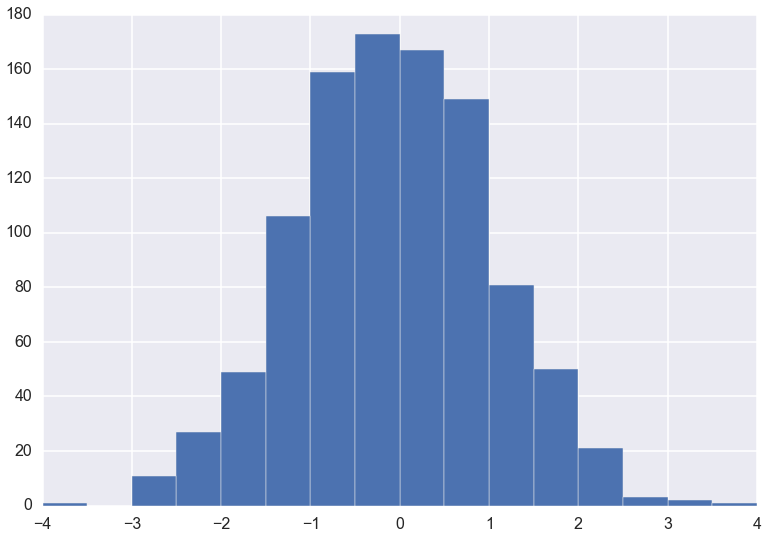

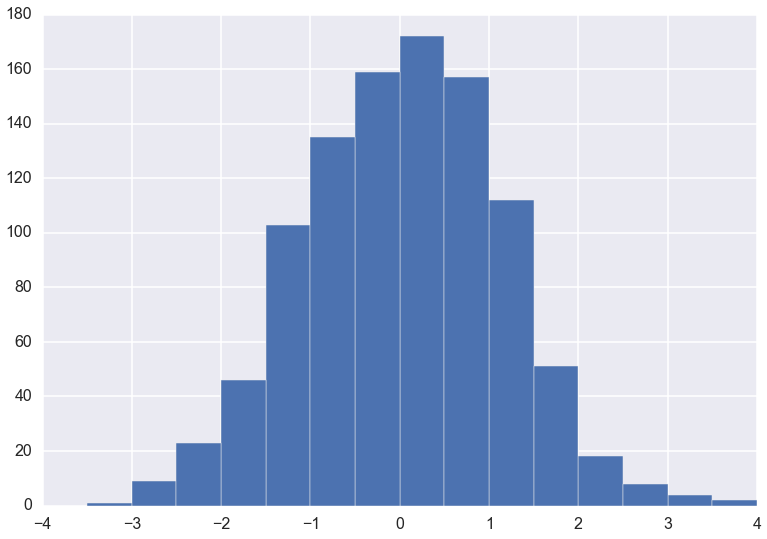

In [8]:
plot_histogram(ys1, 0.5)
plot_histogram(ys2, 0.5)

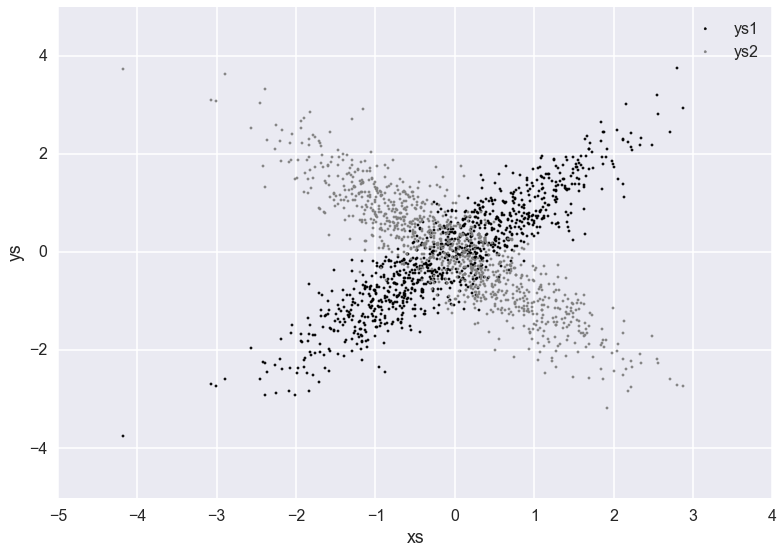

In [9]:
plt.scatter(xs, ys1, marker = '.', color = 'black', label = 'ys1')
plt.scatter(xs, ys2, marker = '.', color = 'gray', label = 'ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc = 'best')

In [10]:
correlation(xs,ys1)

0.9010485800417694

In [11]:
correlation(xs,ys2)

-0.892098584392656

In [12]:
def correlation_matrix(data):
    """return pariwise correlations between all columns of data"""
    
    _, num_columns = shape(data)
    
    def matrix_entry(i,j):
        return correlation(get_column(data, i), get_column(data, j))
    
    return make_matrix(num_columns, num_columns, matrix_entry)

In [13]:
correlation_matrix([[x_i,y_1_i,y_2_i] for x_i, y_1_i, y_2_i in zip(xs,ys1,ys2)])

[[1.0, 0.9010485800417694, -0.892098584392656],
 [0.9010485800417695, 0.9999999999999998, -0.807272900356095],
 [-0.8920985843926559, -0.807272900356095, 1.0]]

### Cleaning and Munging

In [14]:
def try_or_none(f):
    """try to run f if you can't return None"""
    def f_or_none(x):
        try:
            return f(x)
        except:
            return None
    return f_or_none

def parse_row(input_row, parsers):
    """take a given list of parsers and apply each one to a
    particular element of an input_row"""
    
    return [try_or_none(parser)(value) if parser is not None else value
           for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader with parsers to apply"""
    for row in reader:
        yield parse_row(row, parsers)
        
        
def try_parse_field(field_name, value, parser_dict):
    """try to parse a field using the right parser from the dict"""
    parser = parser_dict.get(field_name) # None if it doesn't exist
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return {field_name : try_parse_field(field_name, value, parser_dict)
           for field_name, value in input_dict.iteritems()}

### Manipulating Data

In [15]:
from collections import defaultdict

def picker(field_name):
    """grabs a field from a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform = None):
    # key is output of grouper where value is list of rows
    grouped = defaultdict(list)
    
    for row in rows:
        grouped[grouper(row)].append(row)
        
    if value_transform is None:
        return grouped
    else:
        return {key : value_transform(rows)
               for key,rows in grouped.iteritems()}
    
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort by date
    ordered = sort(grouped_rows, key = picker("date"))
    
    # shift and zip to make pairs then apply tranform
    return [{"symbol": today["symbol"],
             "date": today["date"],
            "change": percent_price_change(yesterday, today)}
            for yesterday, today in zip(ordered, ordered[1:])]

# max(all_changes, key = picker("change"))

def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) / - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

### Rescaling

In [16]:
def scale(data_matrix):
    """returns the means and stdev of the columns"""
    num_rows, num_cols = shape(data_matrix)
    
    means = [mean(get_column(data_matrix, i))
            for i in range(num_cols)]
    
    stdevs = [standard_deviation(get_column(data_matrix, i))
             for i in range(num_cols)]
    
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data columns to standard mean 0 and stdev 1"""
    means, stdev = scale(data_matrix)
    
    def rescaled(i,j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdev[j]
        else:
            return data_matrix[i][j]
        
    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

### PCA

In [17]:
def de_mean_matrix(A):
    """returns the matrix after substracting the mean of the columns from each column"""
    nr, nc = shape(A)
    
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i,j: A[i][j] - column_means[j])

In [18]:
#de_mean_matrix([[x_i,y_1_i] for x_i, y_1_i in zip(xs,ys1)])

In [19]:
from functools import partial

def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance_i(x_i, w):
    """the variance of row x_i in direction of w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """variance of data in direction w"""
    return sum(directional_variance_i(x_i, w)
              for x_i in X)

def directional_variance_gradient_i(x_i, w):
    """contribution of x_i to gradient in direction of w"""
    projection_length = dot(x_i, direction(w))
    
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i, w)
                     for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    
    unscaled_maximizer = maximize_batch(partial(directional_variance, X), # make function of w
                                       partial(directional_variance_gradient, X), # make function of w
                                       guess)
    return direction(unscaled_maximizer)

def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    
    unscaled_maximizer = maximize_stochastic(lambda x, _, w: directional_variance_i(x, w),
                                            lambda x, _, w: directional_variance_gradient_i(x, w),
                                            X,
                                            [None for _ in X],
                                            guess)
    return direction(unscaled_maximizer)

In [20]:
first_principal_component(de_mean_matrix([[x_i,y_1_i] for x_i, y_1_i in zip(xs,ys2)]))

[-0.6633261406888873, 0.7483304290744742]

In [26]:
# This runs ass slow for some reason
#first_principal_component_sgd([[x_i,y_1_i] for x_i, y_1_i in zip(xs,ys2)])

In [27]:
def project(v, w):
    """return the proj of v into w"""
    projection_length = dot(v,w)
    return scalar_multiply(projection_length, w)
# To find others we simply 'remove' this vector from the data
def remove_projection_from_vector(v, w):
    """project v onto w then remove"""
    return vector_subtract(v, project(v,w))

def remove_projection(X, w):
    """for each row of X, project row onto w then remove"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        
        X = remove_projection(X, component)
        
    return components
        
# Make use of this and transform the data
def transform_vector(v, components):
    return [dot(v,w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]